In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


## Dataset

In [44]:
class GenhackDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file, header = None, index_col = 0)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        returns = self.df.iloc[idx].to_numpy().astype(np.float32)

        sample = {'returns': returns}

        if self.transform:
            sample = self.transform(sample)

        return sample

## Model

In [114]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Sigmoid(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

## Hyperparameters

In [115]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-3
z_dim = 128
returns_dim = 4  # 784
batch_size = 32
num_epochs = 50

## Training

In [116]:
disc = Discriminator(returns_dim).to(device)
gen = Generator(z_dim, returns_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [117]:
dataset = GenhackDataset('train.csv')
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
step = 0

for epoch in range(num_epochs):
    for batch_idx, real in enumerate(loader):
        real = real['returns'].view(-1, 4).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()


        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 4, 1)
                data = real.reshape(-1, 1, 4, 1)
                step += 1

Epoch [0/50] Batch 0/24                       Loss D: 0.7038, loss G: 0.7292
Epoch [1/50] Batch 0/24                       Loss D: 0.6882, loss G: 0.6562
Epoch [2/50] Batch 0/24                       Loss D: 0.7031, loss G: 0.6690
Epoch [3/50] Batch 0/24                       Loss D: 0.7013, loss G: 0.6843
Epoch [4/50] Batch 0/24                       Loss D: 0.6997, loss G: 0.6870
Epoch [5/50] Batch 0/24                       Loss D: 0.6972, loss G: 0.6896
Epoch [6/50] Batch 0/24                       Loss D: 0.6949, loss G: 0.6920
Epoch [7/50] Batch 0/24                       Loss D: 0.6922, loss G: 0.6948
Epoch [8/50] Batch 0/24                       Loss D: 0.6862, loss G: 0.7011
Epoch [9/50] Batch 0/24                       Loss D: 0.6806, loss G: 0.7074
Epoch [10/50] Batch 0/24                       Loss D: 0.6704, loss G: 0.7162
Epoch [11/50] Batch 0/24                       Loss D: 0.7934, loss G: 0.7884
Epoch [12/50] Batch 0/24                       Loss D: 0.2626, loss G: 1.5

(array([18.,  7.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([5.4112704e-12, 9.1275331e-03, 1.8255066e-02, 2.7382601e-02,
        3.6510132e-02, 4.5637667e-02, 5.4765202e-02, 6.3892737e-02,
        7.3020265e-02, 8.2147799e-02, 9.1275334e-02], dtype=float32),
 <BarContainer object of 10 artists>)

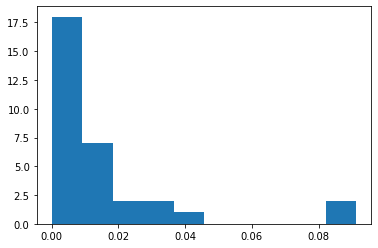

In [119]:
plt.hist(gen(fixed_noise).detach().numpy()[:,0])

## Saving

In [136]:
torch.save(gen.state_dict(), "gen_v1.pt")

In [140]:
torch.save(test_noise, "noise.pt")

## Loading

In [138]:
test = Generator(128,4)
test.load_state_dict(torch.load("gen_v1.pt"))

<All keys matched successfully>

In [141]:
noise = torch.load("noise.pt")

In [142]:
test(noise).detach().numpy()

array([[8.3825178e-03, 4.4803335e-07, 5.9328563e-06, 6.2761601e-10],
       [2.0891335e-02, 2.5249230e-06, 3.6913236e-05, 9.3420290e-08],
       [3.0611085e-02, 6.3855194e-05, 7.2757114e-04, 3.0351000e-06],
       ...,
       [3.7386212e-06, 2.9849848e-13, 8.7184762e-13, 1.3748948e-10],
       [1.3382842e-01, 3.0010738e-03, 4.4446285e-03, 7.9856860e-04],
       [5.8560748e-02, 1.0657033e-05, 5.6028057e-06, 2.0768457e-04]],
      dtype=float32)